# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. 

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

This tutorial explains the LinearMediation class covering linear lagged as well as contemporaneous causal effect and mediation analysis. See the following paper for theoretical background:
Runge, Jakob, Vladimir Petoukhov, Jonathan F. Donges, Jaroslav Hlinka, Nikola Jajcay, Martin Vejmelka, David Hartman, Norbert Marwan, Milan Paluš, and Jürgen Kurths. 2015. “Identifying Causal Gateways and Mediators in Complex Spatio-Temporal Systems.” Nature Communications 6: 8502. https://doi.org/10.1038/ncomms9502.

__Note 1:__ The above paper only covers the lagged case which is here extended.

__Note 2:__ For general linear and nonlinear causal effect analysis including latent variables and further functionality use the CausalEffects class and the tutorial ``tigramite_tutorial_general_causal_effect_analysis.pynb``. However, the LinearMediation class is much faster for its task.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, RobustParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


/home/jakobrunge/work/code/python_code/tigramite/tigramite_v4/tigramite/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: ('Version mismatch. Installed version of torch', '1.10.2', 'Please install torch>=', '1.11.0')
  warnings.warn(str(e))


# Causal effects and mediation

The preceding sections were concerned with estimating causal links. In this section we discuss how the estimated time series graph can be used to evaluate causal effects and causal mediation in a linear framework as discussed in more detail in Runge et al, Nature Communications 2015. 

__Note:__ For a general causal effect analysis please refer to the ``CausalEffects`` class and tutorial.

Consider the following model of a simple causal chain:

\begin{align*}
              X_t &= \eta^X_t \\
              Y_t &= 0.5 X_{t-1} +  \eta^Y_t \\
              Z_t &= 0.5 Y_{t} +  \eta^Z_t
\end{align*}

In [2]:
np.random.seed(42)
# links_coeffs = {0: [],
#                 1: [((0, -1), 0.5)],
#                 2: [((1, -1), 0.5)],
#                 }
def lin_f(x): return x
links_coeffs = {0: [((0,-1), 0.8, lin_f)],
                1: [((1,-1), 0.8, lin_f), ((0, -1), 0.5, lin_f)],
                2: [((2,-1), 0.8, lin_f), ((1, 0), 0.5, lin_f)],
                }
var_names = [r"$X$", r"$Y$", r"$Z$"]
    
data, _ = toys.structural_causal_process(links_coeffs, T=1000)
true_parents = toys._get_true_parent_neighbor_dict(links_coeffs)

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         var_names=var_names)
med = LinearMediation(dataframe=dataframe)
med.fit_model(all_parents=true_parents, tau_max=4)

We fit the linear mediation model based on the true parents here, in practice these could be either known by expert knowledge or estimated with a causal discovery method, eg PCMCIplus. If the assumption of a linear model is justified *and* causal sufficiency is fulfilled, the *link coefficient* of $X_{t-\tau}\to Y_t$ estimated from standardized time series (default in ``LinearMediation`` class) corresponds to the change in the expected value of $Y_t$ (in units of its standard deviation) caused by a perturbation of one standard deviation in $X_{t-\tau}$. Let's check the link coefficient of $X_{t-2}\to Z_t$

In [3]:
print ("Link coefficient (0, -2) --> 2: ", med.get_coeff(i=0, tau=-2, j=2))

Link coefficient (0, -2) --> 2:  0.0


The link coefficient is non-zero only for direct links. The *causal effect* evaluates also *indirect* effects and is now simply computed by summing over the products of link coefficients along all possible paths between the two variables. For example, here the causal effect of $X_{t-2}\to Z_t$ is

In [4]:
print ("Causal effect (0, -2) --> 2: ", med.get_ce(i=0, tau=-2, j=2))

Causal effect (0, -2) --> 2:  0.12044145991096973


The *mediated causal effect* quantifies the contribution of an intermediate variable to the causal effect. For example, let's look at the contribution of $Y$ on the causal effect of $X_{t-2}\to Z_t$.

In [5]:
print ("Mediated Causal effect (0, -2) --> 2 through 1: ", med.get_mce(i=0, tau=-2, j=2, k=1))

Mediated Causal effect (0, -2) --> 2 through 1:  0.12044145991096973


Since $Y$ mediates *all* of the causal effect, MCE is the same as CE here. Mediation analysis is a powerful tool to quantify not only direct causal links, but also indirect pathways. This can answer questions such as "How important is one process for the causal mechanism between two others?". In the ``tigramite.plotting`` module are functions to visualize causal pathways both in the aggregated network and in the time series graph. Here we look at all causal pathways between $X_{t-4}$ and $Z_t$:

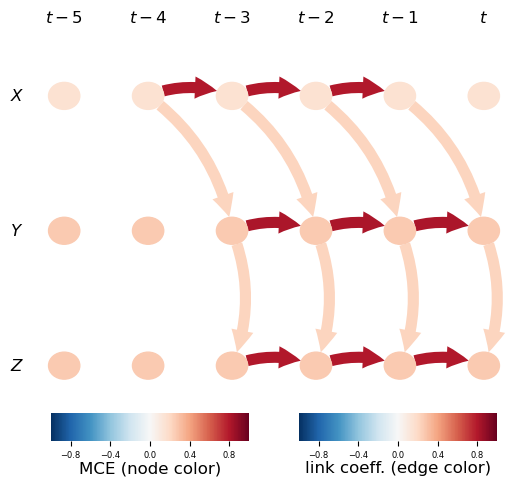

Contemporaneous I(1; 2)=0.223 != I(2; 1)=0.000 due to conditions, finite sample effects or masking, here edge color = larger (absolute) value.


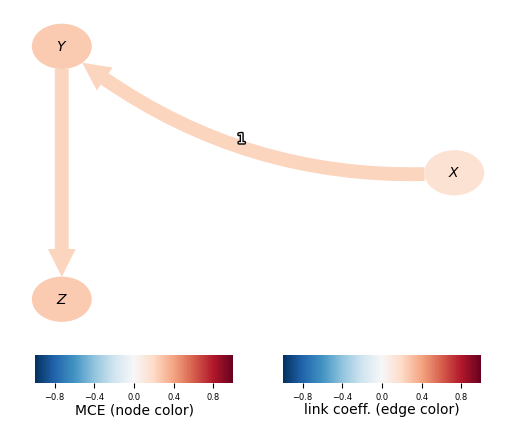

In [6]:
i=0; tau=4; j=2
graph_data = med.get_mediation_graph_data(i=i, tau=tau, j=j)
tp.plot_mediation_time_series_graph(
    var_names=var_names,
    path_node_array=graph_data['path_node_array'],
    tsg_path_val_matrix=graph_data['tsg_path_val_matrix']
    )
tp.plot_mediation_graph(
                    var_names=var_names,
                    path_val_matrix=graph_data['path_val_matrix'], 
                    path_node_array=graph_data['path_node_array'],
                    ); plt.show()

In both plots, the node color depicts the mediation of a variable and the link colors depict the link coefficients. The graph plot in the bottom panel is easier to visualize for more complex pathways, but it's harder to see the pathways across variables *and* in time.

Causal effect and mediation analysis can also be used for more aggregate measures. The Average Causal Effect (ACE) quantifies how strong the effect of a single variable on the whole system is and the Average Causal Susceptibility (ACS) quantifies how strong a single variable is effected by perturbations entering elsewhere in the system. Last, the Average Mediated Causal Effect (AMCE) quantifies how much a single variable mediates causal effects between any two other processes. In Runge et al, Nature Communications (2015), these measures are compared with conventional complex network measures to show that causal effect measures are better interpretable alternatives. For example, *betweenness centrality* gives the average number of shortest paths going through a particular node. However, causal effects do not necessarily take shortest paths and betweenness also does not properly take into account the causal effect weights.

In [7]:
print ("Average Causal Effect X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_ace()))
print ("Average Causal Susceptibility X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_acs()))
print ("Average Mediated Causal Effect X=%.2f, Y=%.2f, Z=%.2f " % tuple(med.get_all_amce()))

Average Causal Effect X=0.37, Y=0.24, Z=0.00 
Average Causal Susceptibility X=0.00, Y=0.24, Z=0.37 
Average Mediated Causal Effect X=0.00, Y=0.13, Z=0.00 


Note that per default self-loops are excluded in these measures. The Mediation class only supports linear causal effects. For non-linear effects the problem is trickier and can be addressed with the ``CausalEffects`` class that also provides much further functionality. However, the LinearMediation class is much faster.

## Bootstrap confidence intervals

For most causal effect functions in ``LinearMediation`` you can also get confidence intervals via a residual-based bootstrap procedure as described in:

        J. Runge et al. (2015): Identifying causal gateways and mediators in
            complex spatio-temporal systems.
            Nature Communications, 6, 8502. http://doi.org/10.1038/ncomms9502

This requires to first apply fit_model_bootstrap(...)

In [ ]:
med.fit_model_bootstrap(generate_noise_from='covariance',
            realizations=100)

In [8]:
# Get Causal effect and 90% confidence interval
print(med.get_ce(i=0, tau=2,  j=2))
print(med.get_bootstrap_of(function='get_ce', 
    function_args={'i':0, 'tau':2,  'j':2}, conf_lev=0.9))

/home/jakobrunge/work/code/python_code/tigramite/tigramite_v4/tigramite/tigramite/models.py:1659: UserWarning: test_indices - maxlag(predictors) [or tau_max] overlaps with train_indices: Choose test_indices such that there is a gap of max_lag to train_indices!
  warnings.warn("test_indices - maxlag(predictors) [or tau_max] "


0.12044145991096973
[0.111573   0.13986352]


In [9]:
# Get Average Mediated Causal Effect and 90% confidence intervals
print(med.get_all_amce())
print(med.get_bootstrap_of(function='get_all_amce', 
    function_args={}, conf_lev=0.9))

[0.00000000e+00 1.30645743e-01 3.33066907e-16]
[[0.00000000e+00 1.22108581e-01 0.00000000e+00]
 [0.00000000e+00 1.48250431e-01 3.05311332e-16]]
